<a href="https://colab.research.google.com/github/psst54/startTensorflow/blob/master/weekly/4_2_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/wikibook/tf2/blob/master/Chapter7.ipynb
를 따름

In [1]:
import tensorflow as tf

path_to_train_file = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
path_to_test_file = tf.keras.utils.get_file('test.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

4898816/4893335 [==============================] - 0s 0us/step


In [2]:
train_text = open(path_to_train_file, 'rb').read().decode(encoding='utf-8')
test_text = open(path_to_test_file, 'rb').read().decode(encoding='utf-8')

print(train_text[:500])

# label : 1(긍정) / 0(부정)

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의 긴장감을 제대로 살려내지못했다.	0
9443947	별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네	0
7156791	액션이 없는데도 재미 있는 몇안되는 영화	1
5912145	왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져


In [3]:
import numpy as np

train_Y = np.array([[int(row.split('\t')[2])] for row in train_text.split('\n')[1:] if row.count('\t') > 0])
test_Y = np.array([[int(row.split('\t')[2])] for row in test_text.split('\n')[1:] if row.count('\t') > 0])

print(train_Y.shape)
print(test_Y.shape)

(150000, 1)
(50000, 1)


In [4]:
# From https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py

import re
def clean_str(string):    
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()

train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]

sentences = [sentence.split(' ') for sentence in train_text_X]
for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


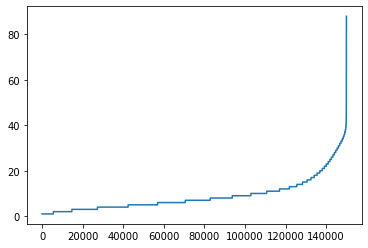

In [5]:
import matplotlib.pyplot as plt
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

In [6]:
# 5글자가 넘는 단어의 길이를 줄인다.
# 25단어 이상의 문장은 그 이상을 생략한다.

sentences_new = []
for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])
sentences = sentences_new
for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조', '가볍지', '않구나']
['너무재밓었']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨', '늙어보이기', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


Tokenizer를 이용해서 등장 빈도 수가 높은 단어만 이용하도록 한다. Tokenizer 함수는 num_words에 지정된 수 마큼만 반환하고, 나머지는 0으로 반환한다. 

pad_sequences 함수는 문장에 패딩을 넣는다. 

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences)
train_X = tokenizer.texts_to_sequences(sentences)
train_X = pad_sequences(train_X, padding='post')

print(train_X[:5])

[[   25   884     8  5795  1111     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  588  5796  6697     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [   71   346    31    35 10468     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  106  5338     4     2  2169   869   573     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]]


In [8]:
model = tf.keras.Sequential([
                             # 임력은 길이 25의 문장이고, 이를 길이 300의 임베딩 벡터로 변환한다.
                             tf.keras.layers.Embedding(20000, 300, input_length=25),
                             tf.keras.layers.LSTM(units=50),
                             tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 300)           6000000   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                70200     
_________________________________________________________________
dense (Dense)                (None, 2)                 102       
Total params: 6,070,302
Trainable params: 6,070,302
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(train_X, train_Y, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
938/938 [==============================] - 60s 64ms/step - loss: 0.4358 - accuracy: 0.7822 - val_loss: 0.3800 - val_accuracy: 0.8215
Epoch 2/5
938/938 [==============================] - 60s 64ms/step - loss: 0.3245 - accuracy: 0.8475 - val_loss: 0.3917 - val_accuracy: 0.8186
Epoch 3/5
938/938 [==============================] - 59s 63ms/step - loss: 0.2700 - accuracy: 0.8702 - val_loss: 0.4125 - val_accuracy: 0.8178
Epoch 4/5
938/938 [==============================] - 59s 63ms/step - loss: 0.2278 - accuracy: 0.8887 - val_loss: 0.5005 - val_accuracy: 0.8050
Epoch 5/5
938/938 [==============================] - 59s 63ms/step - loss: 0.1931 - accuracy: 0.9040 - val_loss: 0.5379 - val_accuracy: 0.8075


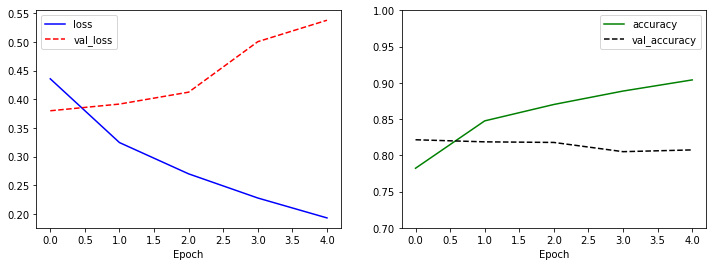

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

검증 데이터에 대해서도 위와 같은 처리를 해준다. 이 과정에서

tokenizer = Tokenizer(num_words=20000)

tokenizer.fit_on_texts(sentences)

의 과정 없이 이미 만들어진 tokenizer를 이용한다.

In [11]:
test_text_X = [row.split('\t')[1] for row in test_text.split('\n')[1:] if row.count('\t') > 0]
test_text_X = [clean_str(sentence) for sentence in test_text_X]
sentences = [sentence.split(' ') for sentence in test_text_X]
sentences_new = []
for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])
sentences = sentences_new

test_X = tokenizer.texts_to_sequences(sentences)
test_X = pad_sequences(test_X, padding='post')

model.evaluate(test_X, test_Y)

1563/1563 [==============================] - 4s 3ms/step - loss: 0.5515 - accuracy: 0.7990


[0.5515024662017822, 0.799019992351532]

In [15]:
test_sentence = '재미있을 줄 알았는데 완전 실망했다. 너무 졸리고 돈이 아까웠다.'
test_sentence = test_sentence.split(' ')
test_sentences = []
now_sentence = []
for word in test_sentence:
    now_sentence.append(word)
    test_sentences.append(now_sentence[:])

test_X_1 = tokenizer.texts_to_sequences(test_sentences)
test_X_1 = pad_sequences(test_X_1, padding = 'post', maxlen=25)

prediction = model.predict(test_X_1)

for idx, sentence in enumerate(test_sentences):
    print(sentence)
    print(prediction[idx])

['재미있을']
[0.6140438  0.38595623]
['재미있을', '줄']
[0.46151322 0.5384868 ]
['재미있을', '줄', '알았는데']
[0.49689475 0.5031053 ]
['재미있을', '줄', '알았는데', '완전']
[0.57615024 0.4238498 ]
['재미있을', '줄', '알았는데', '완전', '실망했다.']
[0.57615024 0.4238498 ]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무']
[0.7238946  0.27610543]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고']
[0.9963595  0.00364047]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이']
[0.99894804 0.00105203]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이', '아까웠다.']
[0.99894804 0.00105203]
